In [8]:
import numpy as np
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from torchsummary import summary
import matplotlib.pyplot as plt

import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
class Sublayer(nn.Module):
    def __init__(self, input_channels):
        super(Sublayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, input_channels*2, 4, 2, 1)
        self.batch= nn.BatchNorm2d(input_channels*2)
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self
class Encode(nn.Module):
    def __init__(self):
        super(Encode, self).__init__()
        self.embed = nn.Embedding(7,256*256)
        self.conv = nn.Conv2d(3+1, 16, 4, 2, 1)
        self.batch= nn.BatchNorm2d(16)
        self.relu =nn.ReLU(True)

        self.lay1=Sublayer(16)
        self.lay2=Sublayer(32)
        self.lay3=Sublayer(64)
        self.lay4=Sublayer(128)
        self.lay5=Sublayer(256)
        self.lay6=Sublayer(512)

        self.maxpool =nn.MaxPool2d((2,2))
        #self.lay7=Sublayer(1024)
    def forward(self,x,c):
        embedding =self.embed(c).view(c.shape[0],1,256,256)
        x = torch.cat([x,embedding],dim=1)
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        x = self.lay6(x)
        x = self.maxpool(x)
        #x = self.lay7(x)
        return x

In [33]:
#summary(Encode(),(3,256,256))

In [10]:
class DeSublayer(nn.Module):
    def __init__(self, input_channels):
        super(DeSublayer, self).__init__()
        self.tconv = nn.ConvTranspose2d(input_channels, int(input_channels/2), 4, 2, 1, bias = False)
        self.batch= nn.BatchNorm2d(int(input_channels/2))
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.tconv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self
class Decode(nn.Module):
    def __init__(self):
        super(Decode, self).__init__()
        #self.tconv1 = nn.ConvTranspose2d(256, 128, 4, 1, 0, bias = False)
        #self.batch= nn.BatchNorm2d(128)
        #self.relu =nn.ReLU(True)
        #self.lay1=DeSublayer(512)
        self.lay2=DeSublayer(256)
        self.lay3=DeSublayer(128)
        self.lay4=DeSublayer(64)
        self.lay5=DeSublayer(32)
        self.lay6=DeSublayer(16)
        self.lay7=DeSublayer(8)
        self.lay8=DeSublayer(4)
        self.tconv2=nn.ConvTranspose2d(2, 3, 4, 2, 1, bias = False)
        self.tanh =nn.Tanh()       
    def forward(self,x):
        #x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        x = self.lay6(x)
        x = self.lay7(x)
        x = self.lay8(x)
        x = self.tconv2(x)
        x = self.tanh(x)
        return x

In [118]:
class DeSublayer(nn.Module):
    def __init__(self, input_channels):
        super(DeSublayer, self).__init__()
        self.tconv = nn.ConvTranspose2d(input_channels, int(input_channels/2), 4, 2, 1, bias = False)
        self.batch= nn.BatchNorm2d(int(input_channels/2))
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.tconv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self

class Decode(nn.Module):
    def __init__(self):
        super(Decode, self).__init__()
        self.embed = nn.Embedding(7,1)
        self.tconv1 = nn.ConvTranspose2d(1024+1, 512, 4, 1, 0, bias = False)
        self.batch= nn.BatchNorm2d(512)
        self.relu =nn.ReLU(True)

        self.lay1=DeSublayer(512)
        self.lay2=DeSublayer(256)
        self.lay3=DeSublayer(128)
        self.lay4=DeSublayer(64)
        self.lay5=DeSublayer(32)
        #self.lay6=DeSublayer(16)

        self.tconv2=nn.ConvTranspose2d(16, 3, 4, 2, 1, bias = False)

        self.tanh =nn.Tanh()
        #self.lay7=Sublayer(1024)
    def forward(self,x,c):
        embedding =self.embed(c).view(c.shape[0],1,1,1)
        #embedding=self.embed(c).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x,embedding],dim=1)
        x = self.tconv1(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        #x = self.lay6(x)
        x = self.tconv2(x)
        x = self.tanh(x)
        #x = self.lay7(x)
        return x

In [22]:
decoder=Decode()
summary(decoder,(1024, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       8,388,608
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
        DeSublayer-7            [-1, 256, 8, 8]               0
   ConvTranspose2d-8          [-1, 128, 16, 16]         524,288
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
       DeSublayer-11          [-1, 128, 16, 16]               0
  ConvTranspose2d-12           [-1, 64, 32, 32]         131,072
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [68]:
Dir_AN='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/AN_train'
Dir_DI='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/DI_train'
Dir_FE='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/FE_train'
Dir_HA='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/HA_train'
Dir_NE='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/NE_train'
Dir_SA='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/SA_train'
Dir_SU='C:/Users/Pro/Desktop/Grp_Project/URGENT!/Jaff_W1/SU_train'

In [82]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
batch_size = 3
folder_AN = ImageFolder(Dir_AN, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
folder_DI = ImageFolder(Dir_DI, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
folder_FE = ImageFolder(Dir_FE, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
folder_HA = ImageFolder(Dir_HA, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
folder_NE = ImageFolder(Dir_NE, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
folder_SA = ImageFolder(Dir_SA, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
folder_SU = ImageFolder(Dir_SU, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))

In [83]:
train_AN = DataLoader(folder_AN, batch_size, shuffle=True, num_workers=3)
train_DI = DataLoader(folder_DI, batch_size, shuffle=True, num_workers=3)
train_FE = DataLoader(folder_FE, batch_size, shuffle=True, num_workers=3)
train_HA = DataLoader(folder_HA, batch_size, shuffle=True, num_workers=3)
train_NE = DataLoader(folder_NE, batch_size, shuffle=True, num_workers=3)
train_SA = DataLoader(folder_SA, batch_size, shuffle=True, num_workers=3)
train_SU = DataLoader(folder_SU, batch_size, shuffle=True, num_workers=3)

In [28]:
#show_batch(train_AN)

In [ ]:
#(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)

In [8]:
image_size = 256
batch_size = 1 #number of image for each trainning
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) #normalization into mean
DIR_All='C:/Users/Pro/Desktop/Grp_Project/URGENT!/All_in'
folder_All = ImageFolder(DIR_All, transform=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)]))
train_All = DataLoader(folder_All, batch_size, shuffle=False, num_workers=3)
#tt.Grayscale(num_output_channels=1),

In [39]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=256):
    fig, ax = plt.subplots(figsize=(10, 50))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=256):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [9]:
def PCA(imgEN):
    imgEN_arr=imgEN.cpu().detach().numpy()#convert tensor into numpy
    encodedImage=np.squeeze(imgEN_arr)
    X=encodedImage
    mean_vector=1/batch_size*np.sum([X[i,:] for i in range(X.shape[0])],axis=0)
    cov=np.zeros((X.shape[1],X.shape[1]))
    #covi=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        covi=X[i]-np.asarray(mean_vector)
        cov+=np.expand_dims(covi,axis=1)*covi
    U, S, V = np.linalg.svd(cov)
    new_X=np.matmul(X,U[:,0:256])#retain 256 parameters with highest sorted variance
    return new_X
def iTensor(PCA_img):
    ed_iT=np.expand_dims(PCA_img, axis=-1)#increase the tensor to fit with the input form
    ed_iT2=np.expand_dims(ed_iT, axis=-1)
    ed_iT2=np.double(ed_iT2)
    preDe=torch.tensor(ed_iT2)
    preDe=preDe.double()
    return preDe

# Conditional

In [84]:
en=Encode()
de=Decode().double()

mse1 = nn.MSELoss()
mse2 = nn.MSELoss()
mse3 = nn.MSELoss()
mse4 = nn.MSELoss()
mse5 = nn.MSELoss()
mse6 = nn.MSELoss()
mse7 = nn.MSELoss()

opt = optim.Adam(list(en.parameters())+list(de.parameters()), lr=2e-5,betas=(0.5,0.999))

In [45]:
for i in range(7):
    print(i)

0
1
2
3
4
5
6


In [72]:
mse=[mse1,mse2,mse3,mse4,mse5,mse6,mse7]

In [47]:
for i, ((AN,l1),(DI,l2),(FE,l2),(HA,l3),(NE,l4),(SA,l5),(SU,l6)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
    data=[AN,DI,FE,HA,NE,SA,SU]
    print(DI.shape)
    print(data[1].shape)

torch.Size([3, 3, 256, 256])
torch.Size([3, 3, 256, 256])


In [64]:
c=torch.tensor(np.array([1, 1, 1]))
embedding = nn.Embedding(7, 1)
embedding(c).view(c.shape[0],1,1,1).shape
#embed(c)

torch.Size([3, 1, 1, 1])

In [65]:
for i, (data,l) in enumerate(train_AN):
    enIMG=en(data,torch.tensor(np.array([1, 1, 1])))
    print(enIMG.shape)
    c=torch.tensor(np.array([1, 1, 1]))
    embedding = nn.Embedding(7, 1)
    emb=embedding(c).view(c.shape[0],1,1,1)
    torch.cat([x,embedding],dim=1)

torch.Size([3, 1024, 1, 1])


In [78]:
k=[]
k.append(torch.tensor(np.array([1, 1, 1])))
k

[tensor([1, 1, 1], dtype=torch.int32)]

In [88]:
num_epochs = 100
#loss=0
for epoch in range(num_epochs):
    for i, ((AN,l1),(DI,l2),(FE,l2),(HA,l3),(NE,l4),(SA,l5),(SU,l6)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
        data=[AN,DI,FE,HA,NE,SA,SU]
        loss=0
        IMGs=[]
        for c in range(7):
            enIMG=en(data[c],c*torch.tensor(np.array([1, 1, 1])))
            deIMG = de(enIMG.double(),c*torch.tensor(np.array([1, 1, 1])))
            IMGs.append(deIMG)
            loss+=mse[c](deIMG.double(),data[c].double())
        opt.zero_grad()
        loss.backward()
        opt.step()
    if epoch%10==0:
        save_image(torch.cat((IMGs[0],IMGs[1],IMGs[2],IMGs[3],IMGs[4],IMGs[5],IMGs[6]),0)*0.5+0.5,f"savedLabels_{epoch+300}.png")


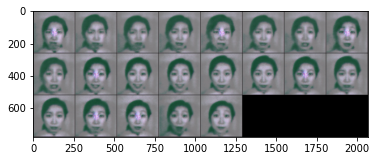

In [123]:
import matplotlib.pyplot as plt
import matplotlib.image as img
  
# reading png image file
im = img.imread('savedLabels_390.png')
  
# show image
plt.imshow(im)

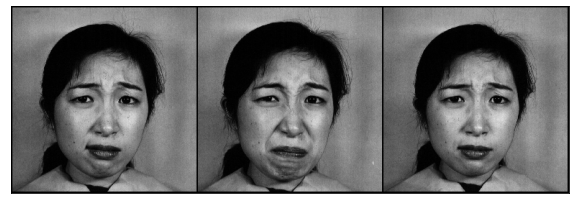

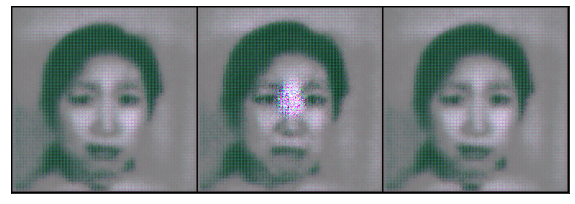

In [95]:
for i, ((AN,l1),(DI,l2),(FE,l2),(HA,l3),(NE,l4),(SA,l5),(SU,l6)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
    show_images(DI)
    enIMG=en(DI,1*torch.tensor(np.array([1, 1, 1])))
    deIMG = de(enIMG.double(),6*torch.tensor(np.array([1, 1, 1])))
    show_images(deIMG)

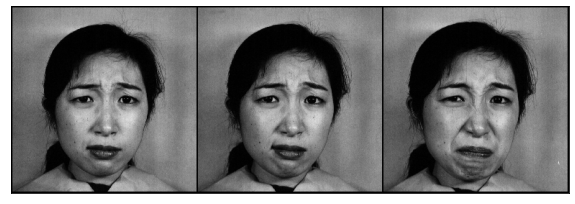

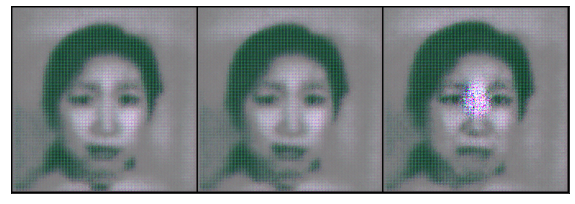

In [120]:
for i, ((AN,l1),(DI,l2),(FE,l2),(HA,l3),(NE,l4),(SA,l5),(SU,l6)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
    show_images(DI)
    enIMG=en(DI,1*torch.tensor(np.array([1, 1, 1])))
    deIMG = de(enIMG.double(),0*torch.tensor(np.array([1, 1, 1])))
    show_images(deIMG)

In [119]:
torch.save(en, 'en1.pt')
torch.save(de, 'de1.pt')

PicklingError: Can't pickle <class '__main__.Encode'>: it's not the same object as __main__.Encode

In [51]:
torch.ones((3))*0

tensor([0., 0., 0.])

In [53]:
torch.tensor(np.array([1, 1, 1]))

tensor([1, 1, 1], dtype=torch.int32)

# 7-BigHands

In [16]:
import torch.optim as optim
en1=Encode()
de1=Decode().double()
en2=Encode()
de2=Decode().double()
en3=Encode()
de3=Decode().double()
en4=Encode()
de4=Decode().double()
en5=Encode()
de5=Decode().double()
en6=Encode()
de6=Decode().double()
en7=Encode()
de7=Decode().double()

mse1 = nn.MSELoss()
mse2 = nn.MSELoss()
mse3 = nn.MSELoss()
mse4 = nn.MSELoss()
mse5 = nn.MSELoss()
mse6 = nn.MSELoss()
mse7 = nn.MSELoss()

opt1 = optim.Adam(list(en1.parameters())+list(de1.parameters()), lr=2e-5,betas=(0.5,0.999))
opt2 = optim.Adam(list(en2.parameters())+list(de2.parameters()), lr=2e-5,betas=(0.5,0.999))
opt3 = optim.Adam(list(en3.parameters())+list(de3.parameters()), lr=2e-5,betas=(0.5,0.999))
opt4 = optim.Adam(list(en4.parameters())+list(de4.parameters()), lr=2e-5,betas=(0.5,0.999))
opt5 = optim.Adam(list(en5.parameters())+list(de5.parameters()), lr=2e-5,betas=(0.5,0.999))
opt6 = optim.Adam(list(en6.parameters())+list(de6.parameters()), lr=2e-5,betas=(0.5,0.999))
opt7 = optim.Adam(list(en7.parameters())+list(de7.parameters()), lr=2e-5,betas=(0.5,0.999))

In [19]:
num_epochs = 100

for epoch in range(num_epochs):
    for i, ((AN,l1),(DI,l2),(FE,l2),(HA,l3),(NE,l4),(SA,l5),(SU,l6)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
        imgEN1 = en1(AN)
        imgDE1 = de1(imgEN1.double())
        loss1 = mse1(AN.double(),imgDE1.double())
        opt1.zero_grad()
        loss1.backward()
        opt1.step()
        
        imgEN2 = en2(DI)
        imgDE2 = de2(imgEN2.double())
        loss2 = mse2(DI.double(),imgDE2.double())
        opt2.zero_grad()
        loss2.backward()
        opt2.step()
        
        imgEN3 = en3(HA)
        imgDE3 = de3(imgEN3.double())
        loss3 = mse3(HA.double(),imgDE3.double())
        opt3.zero_grad()
        loss3.backward()
        opt3.step()
        
        imgEN4 = en4(NE)
        imgDE4 = de4(imgEN4.double())
        loss4 = mse4(NE.double(),imgDE4.double())
        opt4.zero_grad()
        loss4.backward()
        opt4.step()
        
        imgEN5 = en5(SA)
        imgDE5 = de5(imgEN5.double())
        loss5 = mse5(SA.double(),imgDE5.double())
        opt5.zero_grad()
        loss5.backward()
        opt5.step()
        
        imgEN6 = en6(SU)
        imgDE6 = de6(imgEN6.double())
        loss6 = mse6(SU.double(),imgDE6.double())
        opt6.zero_grad()
        loss6.backward()
        opt6.step()
        
        imgEN7 = en7(FE)
        imgDE7 = de7(imgEN7.double())
        loss7 = mse7(FE.double(),imgDE7.double())
        opt7.zero_grad()
        loss7.backward()
        opt7.step()
    if epoch%2==0:
        save_image(torch.cat((imgDE1,imgDE2,imgDE3,imgDE4,imgDE5,imgDE6,imgDE7), 0)*0.5+0.5,f"saved_images_{epoch}.png")

In [18]:
save_image(torch.cat((imgDE1,imgDE2,imgDE3,imgDE4,imgDE5,imgDE6,imgDE7), 0)*0.5+0.5,f"saved_images_{epoch}.png")

In [110]:
enAN=torch.load('enAN.pt')
deAN=torch.load('deAN.pt')
enDI=torch.load('enDI.pt')
deDI=torch.load('deDI.pt')
enHA=torch.load('enHA.pt')
deHA=torch.load('deHA.pt')
enNE=torch.load('enNE.pt')
deNE=torch.load('deNE.pt')
enSA=torch.load('enSA.pt')
deSA=torch.load('deSA.pt')
enSU=torch.load('enSU.pt')
deSU=torch.load('deSU.pt')
enFE=torch.load('enFE.pt')
deFE=torch.load('deFE.pt')

In [107]:
class Sublayer(nn.Module):
    def __init__(self, input_channels):
        super(Sublayer, self).__init__()
        self.conv = nn.Conv2d(input_channels, input_channels*2, 4, 2, 1)
        self.batch= nn.BatchNorm2d(input_channels*2)
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self
class Encode(nn.Module):
    def __init__(self):
        super(Encode, self).__init__()
        self.embed = nn.Embedding(7,256*256)
        self.conv = nn.Conv2d(3, 16, 4, 2, 1)
        self.batch= nn.BatchNorm2d(16)
        self.relu =nn.ReLU(True)

        self.lay1=Sublayer(16)
        self.lay2=Sublayer(32)
        self.lay3=Sublayer(64)
        self.lay4=Sublayer(128)
        self.lay5=Sublayer(256)
        self.lay6=Sublayer(512)

        self.maxpool =nn.MaxPool2d((2,2))
        #self.lay7=Sublayer(1024)
    def forward(self,x):
        #embedding =self.embed(c).view(c.shape[0],1,256,256)
        #x = torch.cat([x,embedding],dim=1)
        x = self.conv(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        x = self.lay6(x)
        x = self.maxpool(x)
        #x = self.lay7(x)
        return x

In [102]:
class DeSublayer(nn.Module):
    def __init__(self, input_channels):
        super(DeSublayer, self).__init__()
        self.tconv = nn.ConvTranspose2d(input_channels, int(input_channels/2), 4, 2, 1, bias = False)
        self.batch= nn.BatchNorm2d(int(input_channels/2))
        self.relu =nn.ReLU(True)
    def forward(self, x):
        x = self.tconv(x)
        x = self.batch(x)
        x = self.relu(x)
        return x
    def get_self(self):
        return self

class Decode(nn.Module):
    def __init__(self):
        super(Decode, self).__init__()
        #self.embed = nn.Embedding(7,1)
        self.tconv1 = nn.ConvTranspose2d(1024, 512, 4, 1, 0, bias = False)
        self.batch= nn.BatchNorm2d(512)
        self.relu =nn.ReLU(True)

        self.lay1=DeSublayer(512)
        self.lay2=DeSublayer(256)
        self.lay3=DeSublayer(128)
        self.lay4=DeSublayer(64)
        self.lay5=DeSublayer(32)
        #self.lay6=DeSublayer(16)

        self.tconv2=nn.ConvTranspose2d(16, 3, 4, 2, 1, bias = False)

        self.tanh =nn.Tanh()
        #self.lay7=Sublayer(1024)
    def forward(self,x):
        #embedding =self.embed(c).view(c.shape[0],1,1,1)
        #embedding=self.embed(c).unsqueeze(2).unsqueeze(3)
        #x = torch.cat([x,embedding],dim=1)
        x = self.tconv1(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.lay1(x)
        x = self.lay2(x)
        x = self.lay3(x)
        x = self.lay4(x)
        x = self.lay5(x)
        #x = self.lay6(x)
        x = self.tconv2(x)
        x = self.tanh(x)
        #x = self.lay7(x)
        return x

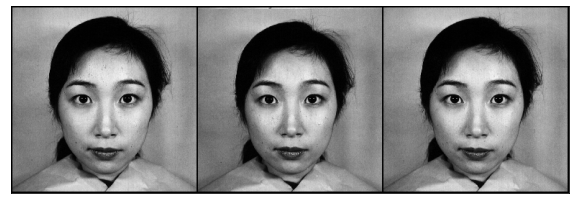

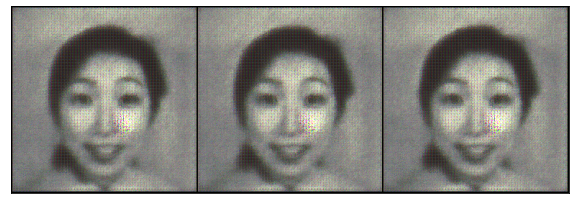

In [111]:
for i, ((AN,l1),(DI,l2),(FE,l2),(HA,l3),(NE,l4),(SA,l5),(SU,l6)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
    show_images(NE)
    imgEN = enNE(NE)
    imgDE = deHA(imgEN.double())
    show_images(imgDE)
    #show_images(deFE3(enAN3(NE).double()))

In [32]:
import numpy as np
total_step = len(train_AN)
loss_list = []
num_epochs = 30

for epoch in range(num_epochs):
    for i, (AN,l1) in enumerate(train_AN):
        #img=torch.cat((AN,DI,FE,HA,NE,SA,SU), 0)
        opt.zero_grad()
        imgEN = encoder(AN)
        #imgPCA = PCA(imgEN)
        #imgTensor = iTensor(imgPCA)
        
        imgDE = decoder(imgEN.double())
        loss = criterion(AN.double(),imgDE.double())
        loss_list.append(loss)

        # Backprop and perform Adam optimisation
        opt.zero_grad()
        loss.backward()
        opt.step()
       
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss))

Epoch [1/20], Step [1/4], Loss: 0.0479
Epoch [1/20], Step [2/4], Loss: 0.0405
Epoch [1/20], Step [3/4], Loss: 0.0585
Epoch [1/20], Step [4/4], Loss: 0.0631
Epoch [2/20], Step [1/4], Loss: 0.0470
Epoch [2/20], Step [2/4], Loss: 0.0401
Epoch [2/20], Step [3/4], Loss: 0.0581
Epoch [2/20], Step [4/4], Loss: 0.0624
Epoch [3/20], Step [1/4], Loss: 0.0467
Epoch [3/20], Step [2/4], Loss: 0.0399
Epoch [3/20], Step [3/4], Loss: 0.0575
Epoch [3/20], Step [4/4], Loss: 0.0619
Epoch [4/20], Step [1/4], Loss: 0.0464
Epoch [4/20], Step [2/4], Loss: 0.0396
Epoch [4/20], Step [3/4], Loss: 0.0573
Epoch [4/20], Step [4/4], Loss: 0.0616
Epoch [5/20], Step [1/4], Loss: 0.0460
Epoch [5/20], Step [2/4], Loss: 0.0393
Epoch [5/20], Step [3/4], Loss: 0.0567
Epoch [5/20], Step [4/4], Loss: 0.0612
Epoch [6/20], Step [1/4], Loss: 0.0458
Epoch [6/20], Step [2/4], Loss: 0.0389
Epoch [6/20], Step [3/4], Loss: 0.0566
Epoch [6/20], Step [4/4], Loss: 0.0607
Epoch [7/20], Step [1/4], Loss: 0.0453
Epoch [7/20], Step [2/4],

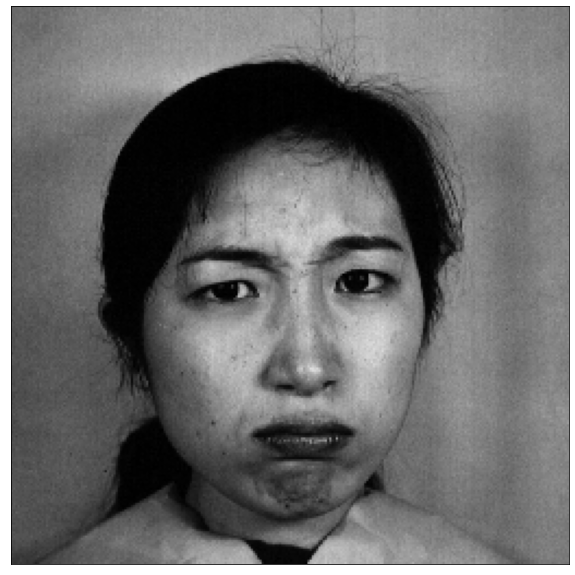

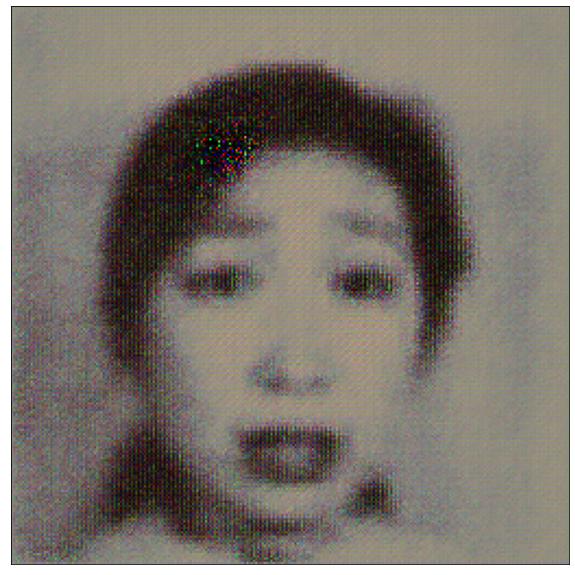

In [33]:
for i, (AN,l1) in enumerate(train_AN):
    if i==2:
        show_images(AN)
        imgEN = en1(AN)
        imgDE = de7(imgEN.double())
        show_images(imgDE)

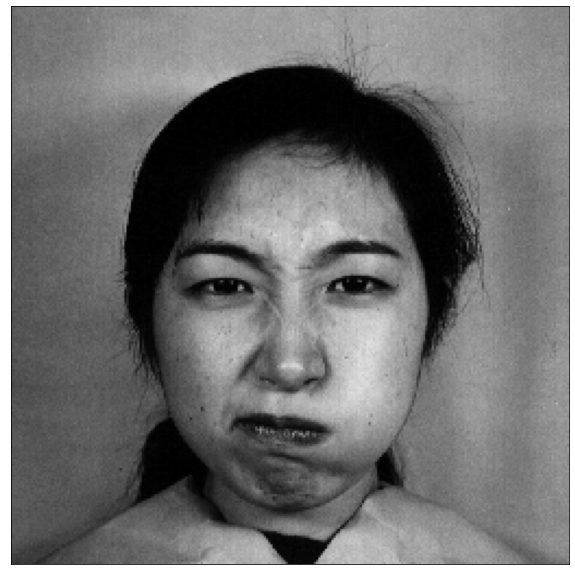

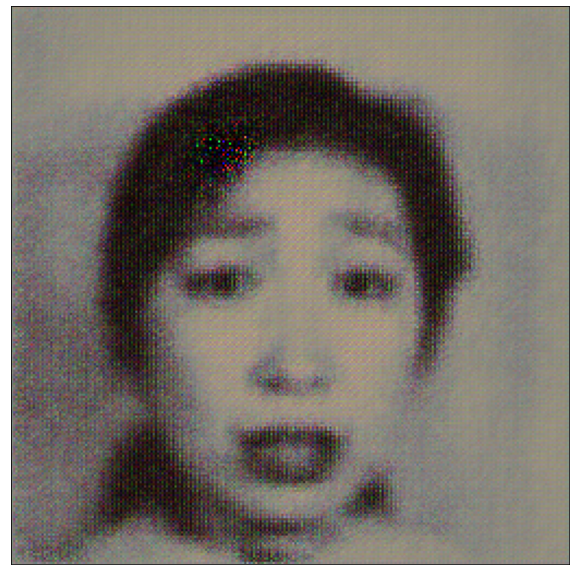

In [37]:
for i, (AN,l1) in enumerate(train_AN):
    if i==2:
        show_images(AN)
        imgEN = en1(AN)
        imgDE = de7(imgEN.double())
        show_images(imgDE)

In [20]:
torch.save(en1, 'enAN3.pt')
torch.save(de1, 'deAN3.pt')
torch.save(en2, 'enDI3.pt')
torch.save(de2, 'deDI3.pt')
torch.save(en3, 'enHA3.pt')
torch.save(de3, 'deHA3.pt')
torch.save(en4, 'enNE3.pt')
torch.save(de4, 'deNE3.pt')
torch.save(en5, 'enSA3.pt')
torch.save(de5, 'deSA3.pt')
torch.save(en6, 'enSU3.pt')
torch.save(de6, 'deSU3.pt')
torch.save(en7, 'enFE3.pt')
torch.save(de7, 'deFE3.pt')

In [35]:
enHA = torch.load('encoderHA.pt')
enHA.eval()
deHA = torch.load('decoderHA.pt')
deHA.eval()

Decode(
  (tconv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (lay1): DeSublayer(
    (tconv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (lay2): DeSublayer(
    (tconv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (lay3): DeSublayer(
    (tconv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (lay4): DeSublayer(
    (t

In [39]:
enAN = torch.load('encoderAN.pt')
enAN.eval()
deAN = torch.load('decoderAN.pt')
deAN.eval()

Decode(
  (tconv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (lay1): DeSublayer(
    (tconv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (lay2): DeSublayer(
    (tconv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (lay3): DeSublayer(
    (tconv): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (lay4): DeSublayer(
    (t

In [54]:
corr_AN = DataLoader(folder_AN, batch_size=30, shuffle=False)
corr_HA = DataLoader(folder_HA, batch_size=31, shuffle=False)

In [57]:
for i, (AN,l1) in enumerate(corr_AN):
    if i==0:
        #show_images(AN)
        imgEN = enAN(AN)
        imgEN_arr=imgEN.cpu().detach().numpy()#convert tensor into numpy
        encodedImage=np.squeeze(imgEN_arr)
        X=encodedImage
        mean_AN=1/30*np.sum([X[i,:] for i in range(X.shape[0])],axis=0)
        
        #imgDE = decoder(imgEN.double())
        #show_images(imgDE)
print(mean_AN)

[0.8258299  1.0218657  1.1542643  ... 0.86241424 1.0016034  0.9835027 ]


In [58]:
for i, (HA,l2) in enumerate(corr_HA):
    if i==0:
        #show_images(AN)
        imgEN = enHA(HA)
        imgEN_arr=imgEN.cpu().detach().numpy()#convert tensor into numpy
        encodedImage=np.squeeze(imgEN_arr)
        X=encodedImage
        mean_HA=1/30*np.sum([X[i,:] for i in range(X.shape[0])],axis=0)
        
        #imgDE = decoder(imgEN.double())
        #show_images(imgDE)
print(mean_HA)

[0.85044354 0.95854324 0.969224   ... 0.9562535  1.0146525  0.971974  ]


In [59]:
import numpy as np
print(np.corrcoef(mean_AN,mean_HA))

[[1.         0.00728488]
 [0.00728488 1.        ]]


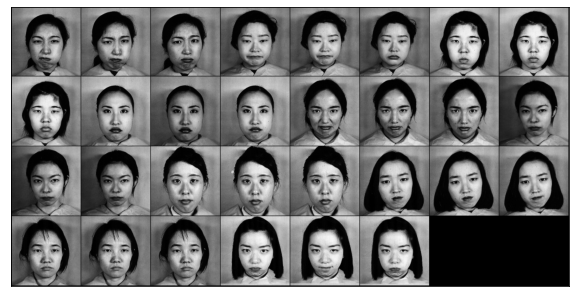

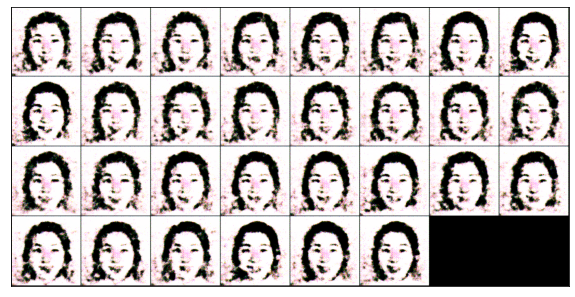

In [62]:
for i, (AN,l1) in enumerate(corr_AN):
    if i==0:
        show_images(AN)
        imgEN = enAN(AN)
        imgEN_arr=imgEN.cpu().detach().numpy()#convert tensor into numpy
        encodedImage=np.squeeze(imgEN_arr)
        X=encodedImage
        mean_AN=1/30*np.sum([X[i,:] for i in range(X.shape[0])],axis=0)
        
        trans_HA=X/0.00728488
        
        ed_iT=np.expand_dims(trans_HA, axis=-1)#increase the tensor to fit with the input form
        ed_iT2=np.expand_dims(ed_iT, axis=-1)
        ed_iT2=np.double(ed_iT2)
        preDe=torch.tensor(ed_iT2)
        preDe=preDe.double()
        decodedHA=deHA(preDe)
        show_images(decodedHA)
        #imgDE = decoder(imgEN.double())

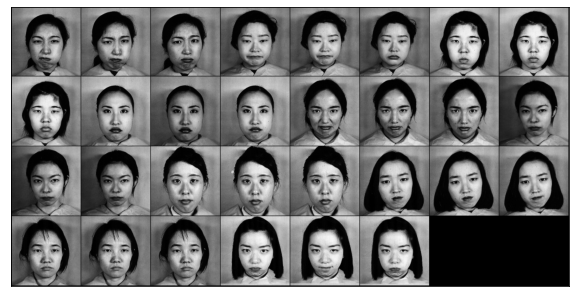

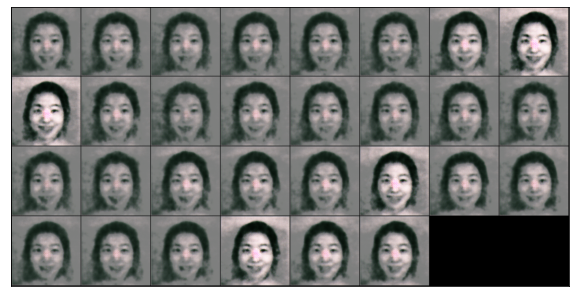

In [50]:
for i, (AN,l1) in enumerate(corr_AN):
    if i==0:
        show_images(AN)
        imgEN = enAN(AN)
        decodedHA =deHA(imgEN.double())
        show_images(decodedHA)
        #imgDE = decoder(imgEN.double())

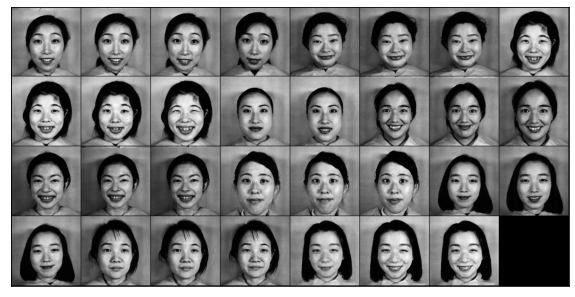

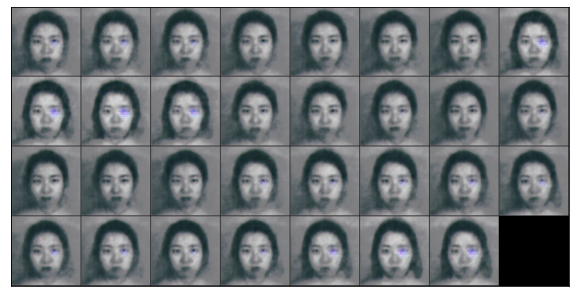

In [56]:
for i, (HA,l1) in enumerate(corr_HA):
    if i==0:
        show_images(HA)
        imgEN = enAN(HA)
        decodedAN =deAN(imgEN.double())
        show_images(decodedAN)
        #imgDE = decoder(imgEN.double())

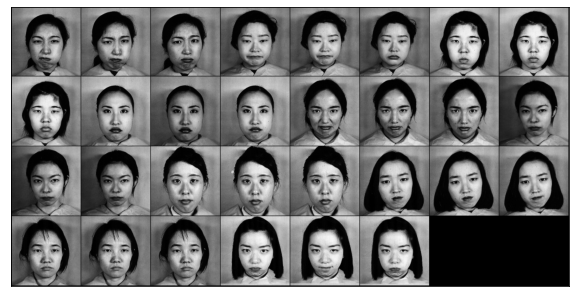

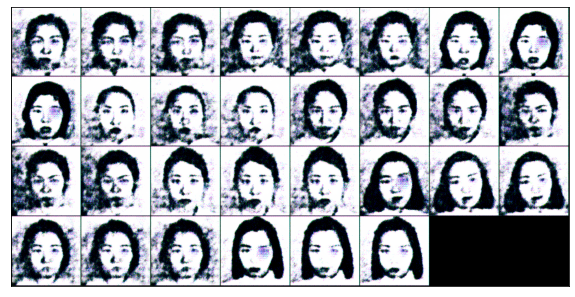

In [52]:
for i, (HA,l1) in enumerate(corr_HA):
    if i==0:
        show_images(HA)
        imgEN = enAN(HA)
        imgEN_arr=imgEN.cpu().detach().numpy()#convert tensor into numpy
        encodedImage=np.squeeze(imgEN_arr)
        X=encodedImage
        mean_HA=1/31*np.sum([X[i,:] for i in range(X.shape[0])],axis=0)
        
        trans_AN=X/0.01366428
        
        ed_iT=np.expand_dims(trans_AN, axis=-1)#increase the tensor to fit with the input form
        ed_iT2=np.expand_dims(ed_iT, axis=-1)
        ed_iT2=np.double(ed_iT2)
        preDe=torch.tensor(ed_iT2)
        preDe=preDe.double()
        decodedAN=deAN(preDe)
        show_images(decodedAN)
        #imgDE = decoder(imgEN.double())

In [ ]:
def PCA(imgEN):
    imgEN_arr=imgEN.cpu().detach().numpy()#convert tensor into numpy
    encodedImage=np.squeeze(imgEN_arr)
    X=encodedImage
    mean_vector=1/batch_size*np.sum([X[i,:] for i in range(X.shape[0])],axis=0)
    cov=np.zeros((X.shape[1],X.shape[1]))
    #covi=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[0]):
        covi=X[i]-np.asarray(mean_vector)
        cov+=np.expand_dims(covi,axis=1)*covi
    U, S, V = np.linalg.svd(cov)
    new_X=np.matmul(X,U[:,0:256])#retain 256 parameters with highest sorted variance
    return new_X
def iTensor(PCA_img):
    ed_iT=np.expand_dims(PCA_img, axis=-1)#increase the tensor to fit with the input form
    ed_iT2=np.expand_dims(ed_iT, axis=-1)
    ed_iT2=np.double(ed_iT2)
    preDe=torch.tensor(ed_iT2)
    preDe=preDe.double()
    return preDe

In [19]:
import numpy as np
total_step = len(train_All)
loss_list = []
acc_list = []
num_epochs = 30

for epoch in range(num_epochs):
    for i, ((AN,l1),(DI,l2),(FE,l3),(HA,l4),(NE,l5),(SA,l6),(SU,l7)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
        img=torch.cat((AN,DI,FE,HA,NE,SA,SU), 0)
        opt.zero_grad()
        imgEN = encoder(img)
        imgPCA = PCA(imgEN)
        imgTensor = iTensor(imgPCA)
        
        imgDE = decoder(imgTensor)
        loss = criterion(img.double(),imgDE)
        loss_list.append(loss)

        # Backprop and perform Adam optimisation
        opt.zero_grad()
        loss.backward()
        opt.step()
       
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss))

Epoch [1/30], Step [1/213], Loss: 0.2018
Epoch [1/30], Step [2/213], Loss: 0.2108
Epoch [1/30], Step [3/213], Loss: 0.2064
Epoch [1/30], Step [4/213], Loss: 0.2254
Epoch [1/30], Step [5/213], Loss: 0.2322
Epoch [1/30], Step [6/213], Loss: 0.2340
Epoch [1/30], Step [7/213], Loss: 0.2877
Epoch [1/30], Step [8/213], Loss: 0.3241
Epoch [1/30], Step [9/213], Loss: 0.3154
Epoch [1/30], Step [10/213], Loss: 0.2356
Epoch [1/30], Step [11/213], Loss: 0.1892
Epoch [1/30], Step [12/213], Loss: 0.1652
Epoch [1/30], Step [13/213], Loss: 0.2010
Epoch [1/30], Step [14/213], Loss: 0.2274
Epoch [1/30], Step [15/213], Loss: 0.2255
Epoch [1/30], Step [16/213], Loss: 0.2490
Epoch [1/30], Step [17/213], Loss: 0.2626
Epoch [1/30], Step [18/213], Loss: 0.2484
Epoch [1/30], Step [19/213], Loss: 0.2269
Epoch [1/30], Step [20/213], Loss: 0.2122
Epoch [1/30], Step [21/213], Loss: 0.2253
Epoch [1/30], Step [22/213], Loss: 0.2673
Epoch [1/30], Step [23/213], Loss: 0.3045
Epoch [1/30], Step [24/213], Loss: 0.2962
E

Epoch [7/30], Step [24/213], Loss: 0.2912
Epoch [7/30], Step [25/213], Loss: 0.2585
Epoch [7/30], Step [26/213], Loss: 0.2417
Epoch [7/30], Step [27/213], Loss: 0.2553
Epoch [7/30], Step [28/213], Loss: 0.3142
Epoch [7/30], Step [29/213], Loss: 0.3399
Epoch [8/30], Step [1/213], Loss: 0.1981
Epoch [8/30], Step [2/213], Loss: 0.2070
Epoch [8/30], Step [3/213], Loss: 0.2028
Epoch [8/30], Step [4/213], Loss: 0.2211
Epoch [8/30], Step [5/213], Loss: 0.2273
Epoch [8/30], Step [6/213], Loss: 0.2292
Epoch [8/30], Step [7/213], Loss: 0.2815
Epoch [8/30], Step [8/213], Loss: 0.3176
Epoch [8/30], Step [9/213], Loss: 0.3092
Epoch [8/30], Step [10/213], Loss: 0.2307
Epoch [8/30], Step [11/213], Loss: 0.1848
Epoch [8/30], Step [12/213], Loss: 0.1604
Epoch [8/30], Step [13/213], Loss: 0.1965
Epoch [8/30], Step [14/213], Loss: 0.2236
Epoch [8/30], Step [15/213], Loss: 0.2216
Epoch [8/30], Step [16/213], Loss: 0.2445
Epoch [8/30], Step [17/213], Loss: 0.2574
Epoch [8/30], Step [18/213], Loss: 0.2428
E

Epoch [14/30], Step [15/213], Loss: 0.2130
Epoch [14/30], Step [16/213], Loss: 0.2349
Epoch [14/30], Step [17/213], Loss: 0.2449
Epoch [14/30], Step [18/213], Loss: 0.2317
Epoch [14/30], Step [19/213], Loss: 0.2130
Epoch [14/30], Step [20/213], Loss: 0.1992
Epoch [14/30], Step [21/213], Loss: 0.2104
Epoch [14/30], Step [22/213], Loss: 0.2502
Epoch [14/30], Step [23/213], Loss: 0.2859
Epoch [14/30], Step [24/213], Loss: 0.2785
Epoch [14/30], Step [25/213], Loss: 0.2474
Epoch [14/30], Step [26/213], Loss: 0.2314
Epoch [14/30], Step [27/213], Loss: 0.2439
Epoch [14/30], Step [28/213], Loss: 0.3008
Epoch [14/30], Step [29/213], Loss: 0.3253
Epoch [15/30], Step [1/213], Loss: 0.1897
Epoch [15/30], Step [2/213], Loss: 0.1981
Epoch [15/30], Step [3/213], Loss: 0.1940
Epoch [15/30], Step [4/213], Loss: 0.2114
Epoch [15/30], Step [5/213], Loss: 0.2171
Epoch [15/30], Step [6/213], Loss: 0.2189
Epoch [15/30], Step [7/213], Loss: 0.2690
Epoch [15/30], Step [8/213], Loss: 0.3044
Epoch [15/30], Step

Epoch [21/30], Step [4/213], Loss: 0.1993
Epoch [21/30], Step [5/213], Loss: 0.2045
Epoch [21/30], Step [6/213], Loss: 0.2060
Epoch [21/30], Step [7/213], Loss: 0.2543
Epoch [21/30], Step [8/213], Loss: 0.2897
Epoch [21/30], Step [9/213], Loss: 0.2814
Epoch [21/30], Step [10/213], Loss: 0.2090
Epoch [21/30], Step [11/213], Loss: 0.1652
Epoch [21/30], Step [12/213], Loss: 0.1439
Epoch [21/30], Step [13/213], Loss: 0.1744
Epoch [21/30], Step [14/213], Loss: 0.1995
Epoch [21/30], Step [15/213], Loss: 0.1975
Epoch [21/30], Step [16/213], Loss: 0.2171
Epoch [21/30], Step [17/213], Loss: 0.2256
Epoch [21/30], Step [18/213], Loss: 0.2130
Epoch [21/30], Step [19/213], Loss: 0.1980
Epoch [21/30], Step [20/213], Loss: 0.1864
Epoch [21/30], Step [21/213], Loss: 0.1963
Epoch [21/30], Step [22/213], Loss: 0.2340
Epoch [21/30], Step [23/213], Loss: 0.2678
Epoch [21/30], Step [24/213], Loss: 0.2608
Epoch [21/30], Step [25/213], Loss: 0.2318
Epoch [21/30], Step [26/213], Loss: 0.2164
Epoch [21/30], St

Epoch [27/30], Step [22/213], Loss: 0.2196
Epoch [27/30], Step [23/213], Loss: 0.2519
Epoch [27/30], Step [24/213], Loss: 0.2452
Epoch [27/30], Step [25/213], Loss: 0.2176
Epoch [27/30], Step [26/213], Loss: 0.2034
Epoch [27/30], Step [27/213], Loss: 0.2134
Epoch [27/30], Step [28/213], Loss: 0.2651
Epoch [27/30], Step [29/213], Loss: 0.2881
Epoch [28/30], Step [1/213], Loss: 0.1666
Epoch [28/30], Step [2/213], Loss: 0.1742
Epoch [28/30], Step [3/213], Loss: 0.1701
Epoch [28/30], Step [4/213], Loss: 0.1844
Epoch [28/30], Step [5/213], Loss: 0.1889
Epoch [28/30], Step [6/213], Loss: 0.1905
Epoch [28/30], Step [7/213], Loss: 0.2358
Epoch [28/30], Step [8/213], Loss: 0.2711
Epoch [28/30], Step [9/213], Loss: 0.2626
Epoch [28/30], Step [10/213], Loss: 0.1952
Epoch [28/30], Step [11/213], Loss: 0.1525
Epoch [28/30], Step [12/213], Loss: 0.1340
Epoch [28/30], Step [13/213], Loss: 0.1603
Epoch [28/30], Step [14/213], Loss: 0.1843
Epoch [28/30], Step [15/213], Loss: 0.1825
Epoch [28/30], Step 

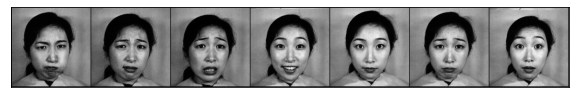

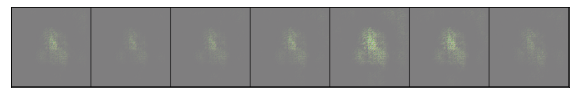

In [18]:
for i, ((AN,l1),(DI,l2),(FE,l3),(HA,l4),(NE,l5),(SA,l6),(SU,l7)) in enumerate(zip(train_AN,train_DI,train_FE,train_HA,train_NE,train_SA,train_SU)):
    if i==1:
        img=torch.cat((AN,DI,FE,HA,NE,SA,SU), 0)
        show_images(img)
        imgEN = encoder(img)
        imgPCA = PCA(imgEN)
        imgTensor = iTensor(imgPCA)
        imgDE = decoder(imgTensor)
        show_images(imgDE)